<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/cntk_pixel_landcover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reference for cntk model https://github.com/Azure/pixel_level_land_classification/blob/master/geoaidsvm/03_Apply_trained_model_to_new_data.ipynb

In [ ]:
!apt-get install --no-install-recommends openmpi-bin libopenmpi-dev libopencv-dev python3-opencv python-opencv && ln -sf /usr/lib/x86_64-linux-gnu/libmpi_cxx.so /usr/lib/x86_64-linux-gnu/libmpi_cxx.so.1 && ln -sf /usr/lib/x86_64-linux-gnu/openmpi/lib/libmpi.so /usr/lib/x86_64-linux-gnu/openmpi/lib/libmpi.so.12 && ln -sf /usr/lib/x86_64-linux-gnu/libmpi.so /usr/lib/x86_64-linux-gnu/libmpi.so.12

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenmpi-dev is already the newest version (2.1.1-8).
openmpi-bin is already the newest version (2.1.1-8).
libopencv-dev is already the newest version (3.2.0+dfsg-4ubuntu0.1).
python-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
python3-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
!pip install cntk

In [ ]:
!wget https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/2792_nlcd-2013.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/2792_nlcd-2016.tif

--2020-12-22 01:43:10--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/2792_nlcd-2013.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524021 (512K) [application/octet-stream]
Saving to: ‘2792_nlcd-2013.tif.2’

2792_nlcd-2013.tif. 100%[===================>] 511.74K  1.09MB/s    in 0.5s    

2020-12-22 01:43:11 (1.09 MB/s) - ‘2792_nlcd-2013.tif.2’ saved [524021/524021]

--2020-12-22 01:43:11--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/2792_nlcd-2016.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158 (513K) [application/octet-st

In [ ]:
!wget https://dfc2021.blob.core.windows.net/competition-data/naip-2013/2792_naip-2013.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/naip-2017/2792_naip-2017.tif

--2020-12-22 01:43:12--  https://dfc2021.blob.core.windows.net/competition-data/naip-2013/2792_naip-2013.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57758915 (55M) [application/octet-stream]
Saving to: ‘2792_naip-2013.tif.2’

2792_naip-2013.tif. 100%[===================>]  55.08M  13.9MB/s    in 4.0s    

2020-12-22 01:43:16 (13.9 MB/s) - ‘2792_naip-2013.tif.2’ saved [57758915/57758915]

--2020-12-22 01:43:16--  https://dfc2021.blob.core.windows.net/competition-data/naip-2017/2792_naip-2017.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60474233 (58M) [application/oc

In [ ]:
import cntk
import gdal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

/usr/local/lib/python3.6/dist-packages/cntk/cntk_py_init.py:56: UserWarning: Unsupported Linux distribution (ubuntu-18.04). CNTK supports Ubuntu 16.04 and above, only.
  warnings.warn('Unsupported Linux distribution (%s-%s). CNTK supports Ubuntu 16.04 and above, only.' % (__my_distro__, __my_distro_ver__))


In [ ]:
def naip_to_np(naip_path):
  return gdal.Open(naip_path).ReadAsArray().astype(float)/255
naip_arr = naip_to_np("/content/2792_naip-2013.tif")

In [ ]:
pad=64
naip_pad = np.pad(naip_arr,[(0,0),(pad,pad),(pad,pad)])

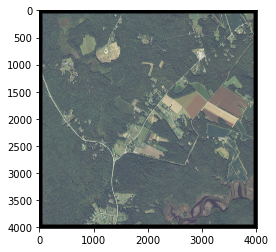

In [ ]:
plt.imshow(naip_pad[0:3,:,:].transpose([1,2,0]))

In [ ]:
model_filename = "/content/250epochs.model"
model = cntk.load_model(model_filename)
# (4,256,256) is expected input size

#250epochs.model classes 
No data: 0

Water: 1

Trees: 2

Herbaceous: 3

Barren/impervious: 4

In [ ]:
region_dim = 3880
n_rows = int(region_dim / 128)

# The model's predictions will have five values for each x-y position:
# these can be used to find the relative predicted probabilities of
# each of the five labels.
pred_lc_image = np.zeros((5, naip_pad.shape[1], naip_pad.shape[2]))

t1 = time.time()
for row_idx in range(n_rows):
    for col_idx in range(n_rows):
        # Extract a 256 x 256 region from the NAIP image, to feed into the model.
        sq_naip = naip_pad[:,
                             row_idx * 128:(row_idx * 128) + 256,
                             col_idx * 128:(col_idx * 128) + 256]
        
        # Get the model's prediction for the center of that region
        sq_pred_lc = np.squeeze(model.eval({model.arguments[0]: [sq_naip]}))
        
        # Save the predictions in the appropriate region of the result matrix
        pred_lc_image[:,
                      row_idx * 128:(row_idx * 128) + 128,
                      col_idx * 128:(col_idx * 128) + 128] = sq_pred_lc
print(time.time()-t1)


/usr/local/lib/python3.6/dist-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


515.0391364097595


#very slow 5 min for 3880 x 3880?

In [ ]:
def nlcd_to_target(batch_label):
    """
    Input:
    np.array or tf.tensor of shape (batch,Width,Height) corresponding to NLCD labeled data
    Returns:
    np.array of shape (batch,width,height)
    corresponding pixel level Target Class labels {0:"Water",1:"Tree Canopy", 2:"Low Vegetation", 3:"Impervious"}
    """
    labeldict={11:0,21:2,22:3,23:3,24:3,31:2,41:1,42:1,43:1,52:1,71:2,81:2,82:2,90:2,95:1}
    return np.vectorize(labeldict.__getitem__)(batch_label) 

def nlcd_to_one_hot(batch_label, num_classes):
  """
  Input:
  np.array or tf.tensor of shape (batch,Width,Height) corresponding to NLCD labeled data
  Returns:
  np.array of shape (batch,width,height,4)
  corresponding to the one hot encoding at pixel level of Target Class {0:"Water",1:"Tree Canopy", 2:"Low Vegetation", 3:"Impervious"}
  """

  targetlabel = nlcd_to_target(batch_label)
  return tf.one_hot(targetlabel,depth = num_classes,axis=-1)

In [ ]:
nlcd = gdal.Open("/content/2792_nlcd-2013.tif").ReadAsArray()

In [ ]:
nlcd_im = nlcd_to_target(nlcd)
nlcd_oh = nlcd_to_one_hot(nlcd,4)

#nlcd target labels

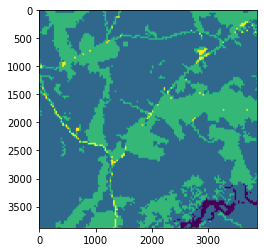

In [ ]:
plt.imshow(nlcd_im)

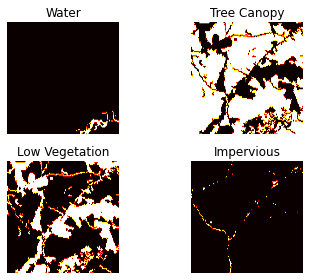

In [ ]:
targetdict={0:"Water",1:"Tree Canopy", 2:"Low Vegetation", 3:"Impervious"}
fig, axs = plt.subplots(2, 2)
for i, subplot in enumerate(axs.flat):
  subplot.imshow(nlcd_oh[:,:,i],cmap="hot")
  subplot.set_title(targetdict[i])
  subplot.axis("off")
fig.tight_layout()
plt.show()

#cntk predicted labels

In [ ]:
predictions = tf.round(tf.nn.softmax(
    pred_lc_image, axis=0, name=None))

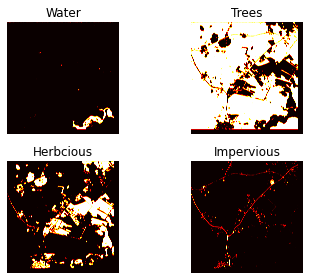

In [ ]:
targetdict2={0:"Water",1:"Trees", 2:"Herbcious", 3:"Impervious"}
fig, axs = plt.subplots(2, 2)
for i, subplot in enumerate(axs.flat):
  subplot.imshow(predictions[i+1,:,:],cmap="hot")
  subplot.set_title(targetdict2[i])
  subplot.axis("off")
fig.tight_layout()
plt.show()